In [80]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [81]:
data_dir = "/Users/kanadb/Work/IIT-KGP Summer/cancer-research/datasets/TCGA-BRCA-CNV-tumor-Gene-Level-10"
file_pattern = "**/*.tsv"

file_paths = glob.glob(os.path.join(data_dir, file_pattern), recursive=True)

In [82]:
all_cnv_counts = []
all_merged_dfs = []

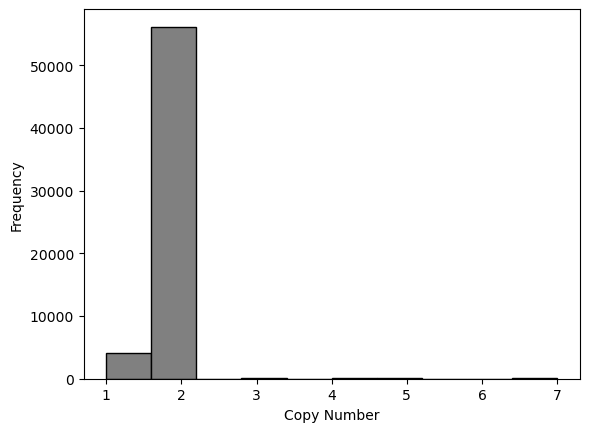

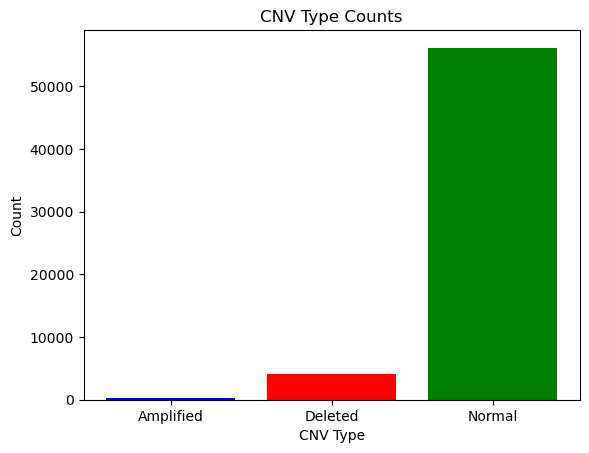

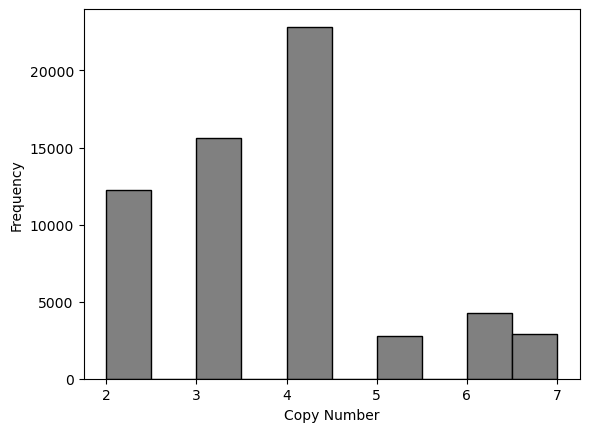

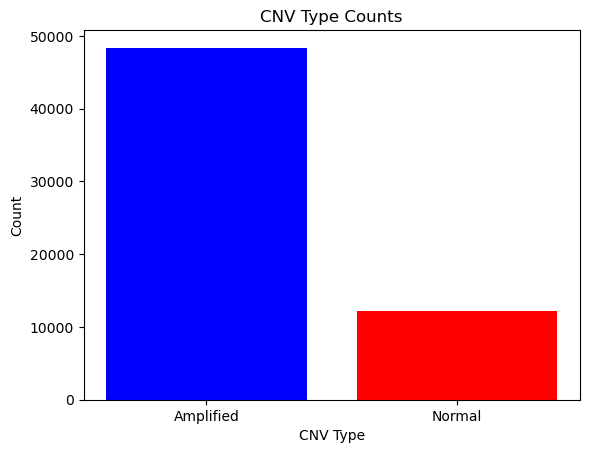

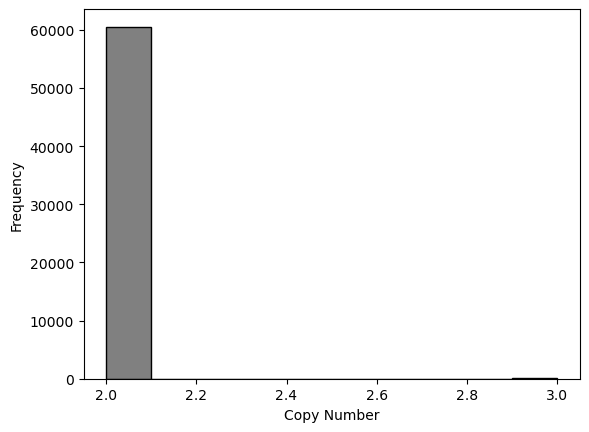

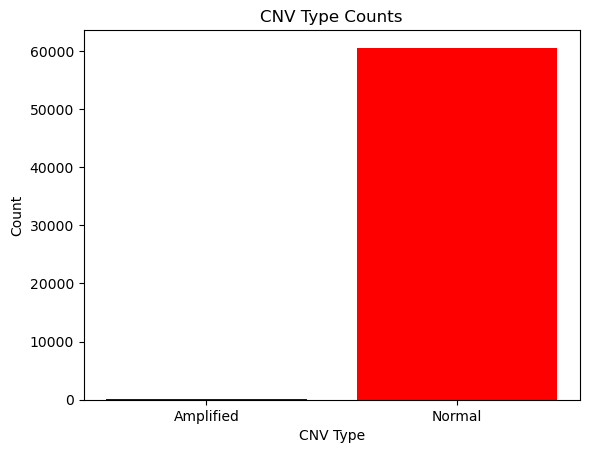

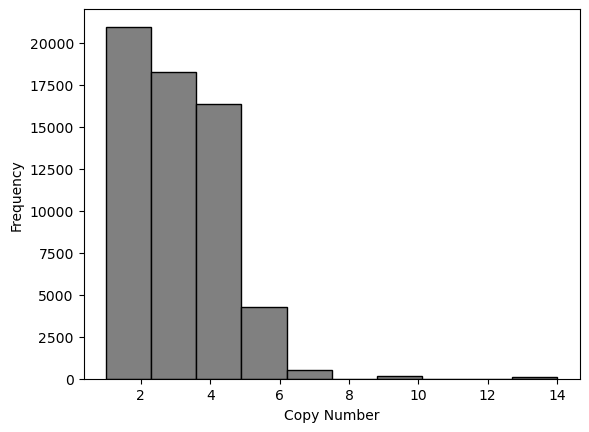

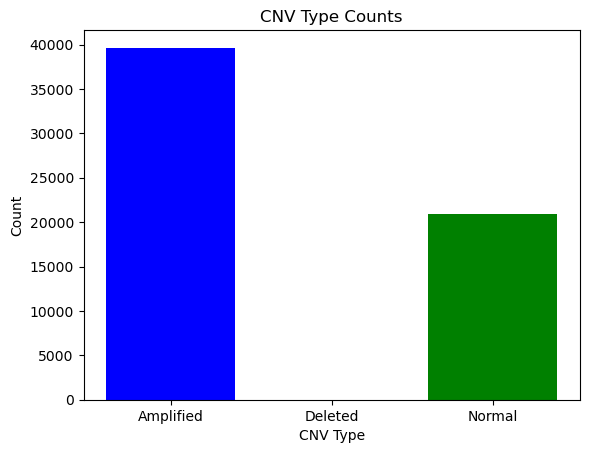

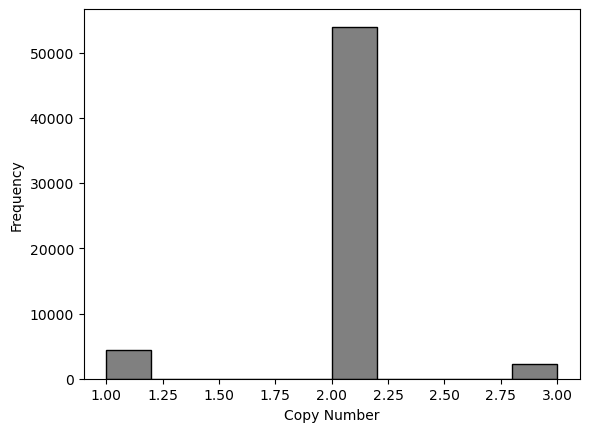

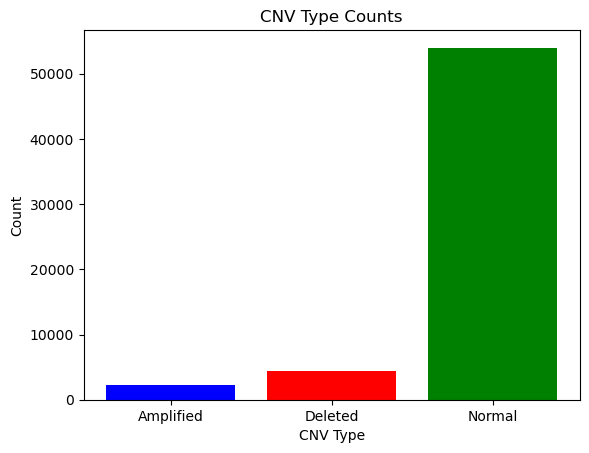

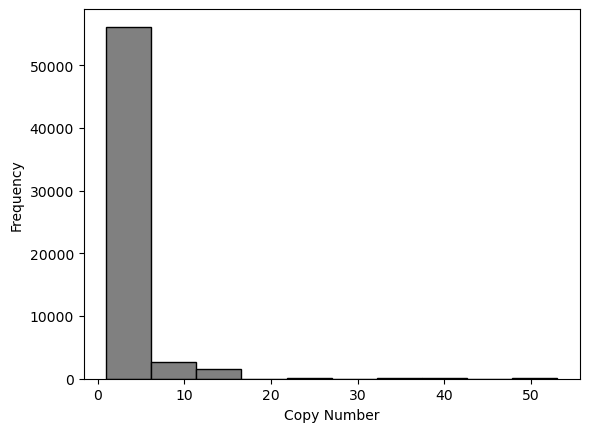

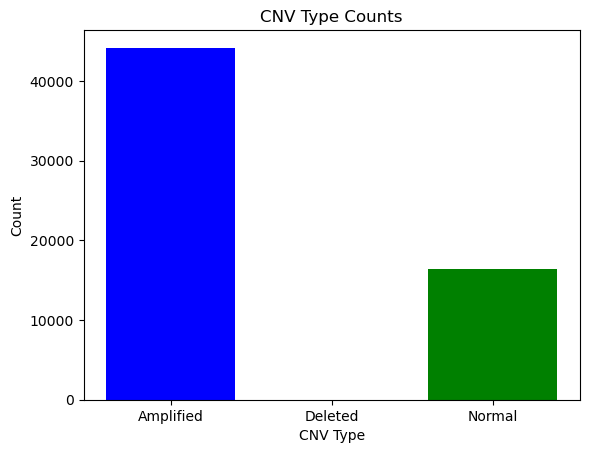

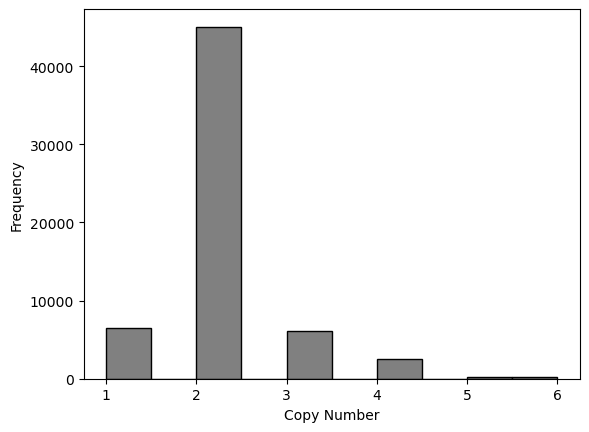

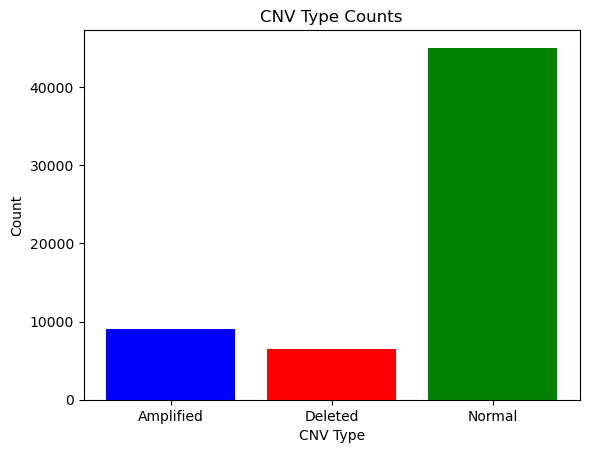

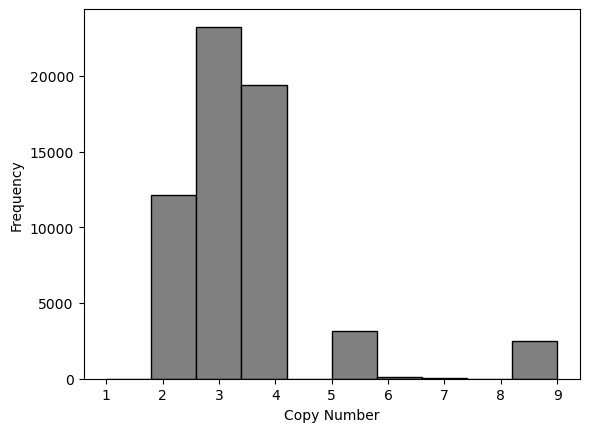

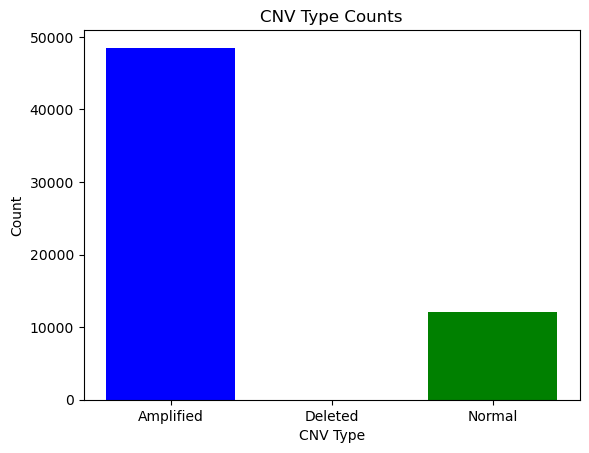

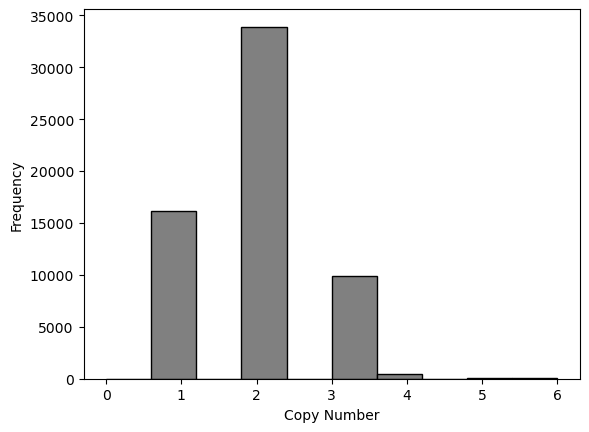

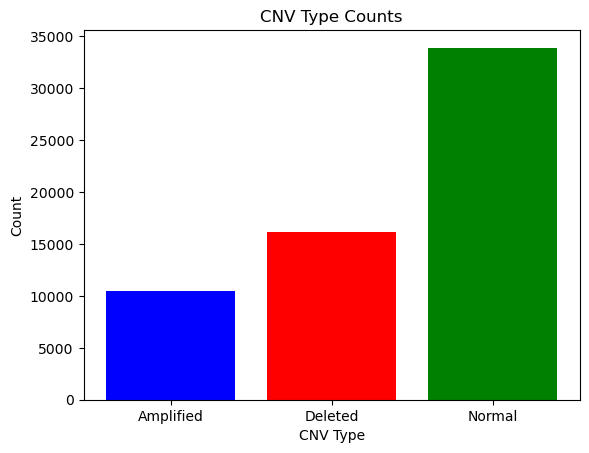

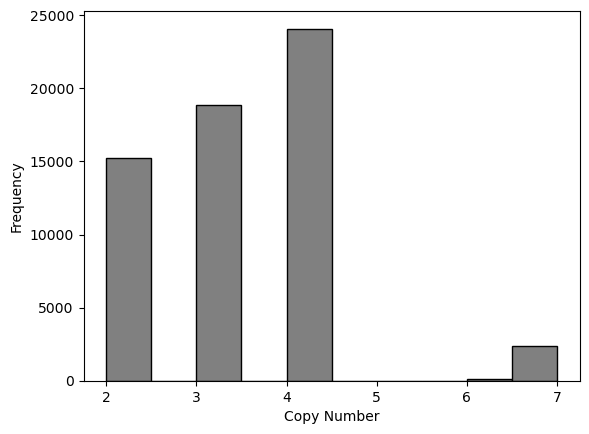

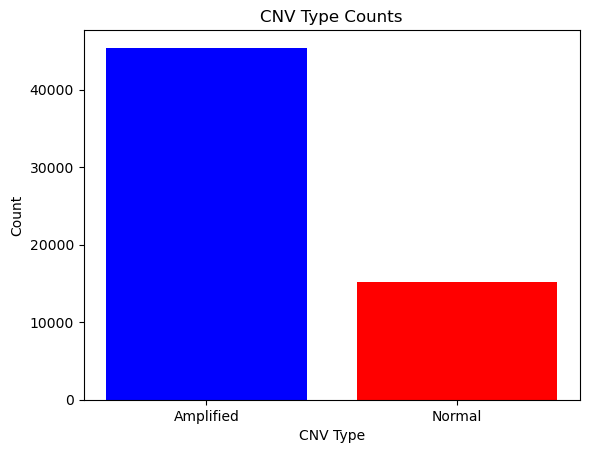

In [83]:
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path, sep='\t')
        df.columns = [col.strip() for col in df.columns]

        # Convert column data type
        df['start'] = pd.to_numeric(df['start'], errors='coerce')
        df['end'] = pd.to_numeric(df['end'], errors='coerce')
        df['copy_number'] = pd.to_numeric(df['copy_number'], errors='coerce')
        df['min_copy_number'] = pd.to_numeric(df['min_copy_number'], errors='coerce')
        df['max_copy_number'] = pd.to_numeric(df['max_copy_number'], errors='coerce')

        # Handle missing genomic positions
        df['start'] = df['start'].ffill().bfill()
        df['end'] = df['end'].ffill().bfill()

        # Impute missing CN values with normal value 2
        imputer = SimpleImputer(strategy='constant', fill_value=2)
        copy_cols = ['copy_number', 'min_copy_number', 'max_copy_number']
        df[copy_cols] = imputer.fit_transform(df[copy_cols])

        # Classify CNV type
        def classify(cn):
            if cn > 2:
                return "Amplified"
            elif cn < 2:
                return "Deleted"
            else:
                return "Normal"
        df['CNV_Type'] = df['copy_number'].apply(classify)

        # Store dataframe
        all_merged_dfs.append(df)

        # Count CNV counts per sample
        cnv_counts = df['CNV_Type'].value_counts().reindex(["Amplified", "Deleted", "Normal"], fill_value=0)
        all_cnv_counts.append(cnv_counts)

        # Histogram Plot
        plt.hist(df['copy_number'], color='gray', edgecolor='black')
        plt.xlabel('Copy Number')
        plt.ylabel('Frequency')
        plt.show()

        # CNV Types Plot
        cnv_types = df['CNV_Type'].value_counts().sort_index()
        plt.bar(cnv_types.index, cnv_types.values, color=['blue', 'red', 'green'])
        plt.title('CNV Type Counts')
        plt.xlabel('CNV Type')
        plt.ylabel('Count')
        plt.show()

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [84]:
merged_df = pd.concat(all_merged_dfs, ignore_index=True)
merged_df.shape

(606230, 9)

In [85]:
merged_df.head()

,gene_id,gene_name,chromosome,start,end,copy_number,min_copy_number,max_copy_number,CNV_Type
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,2.0,2.0,2.0,Normal
1,ENSG00000227232.5,WASH7P,chr1,14404,29570,2.0,2.0,2.0,Normal
2,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,2.0,2.0,2.0,Normal
3,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,2.0,2.0,2.0,Normal
4,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,2.0,2.0,2.0,Normal


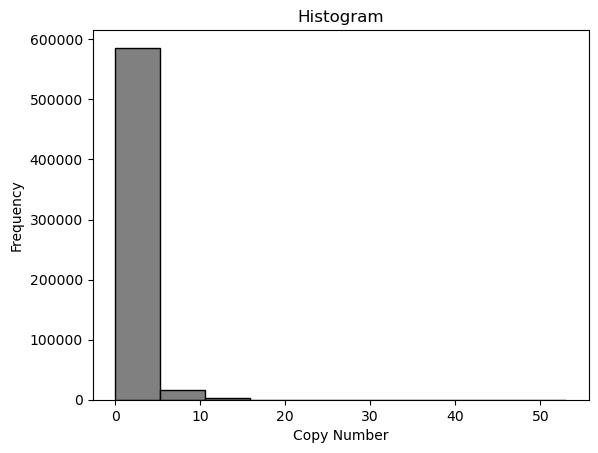

In [86]:
plt.hist(merged_df['copy_number'], color='gray', edgecolor='black')

plt.title('Histogram')
plt.xlabel('Copy Number')
plt.ylabel('Frequency')

plt.show()

In [87]:
cnv_types = merged_df['CNV_Type'].value_counts().sort_index()
cnv_types

CNV_Type
Amplified    248313
Deleted       31264
Normal       326653
Name: count, dtype: int64

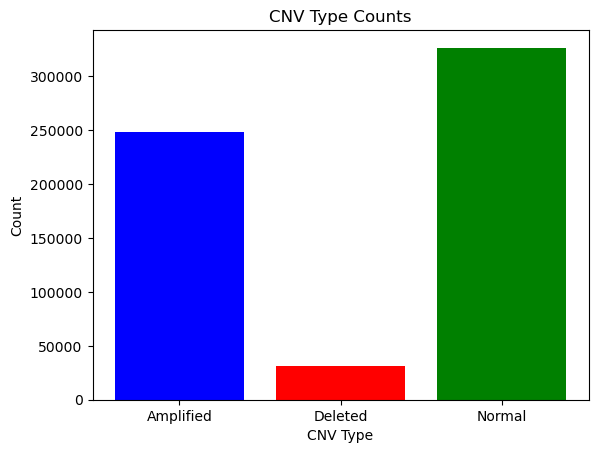

In [88]:
plt.bar(cnv_types.index, cnv_types.values, color=['blue', 'red', 'green'])

plt.title('CNV Type Counts')
plt.xlabel('CNV Type')
plt.ylabel('Count')

plt.show()

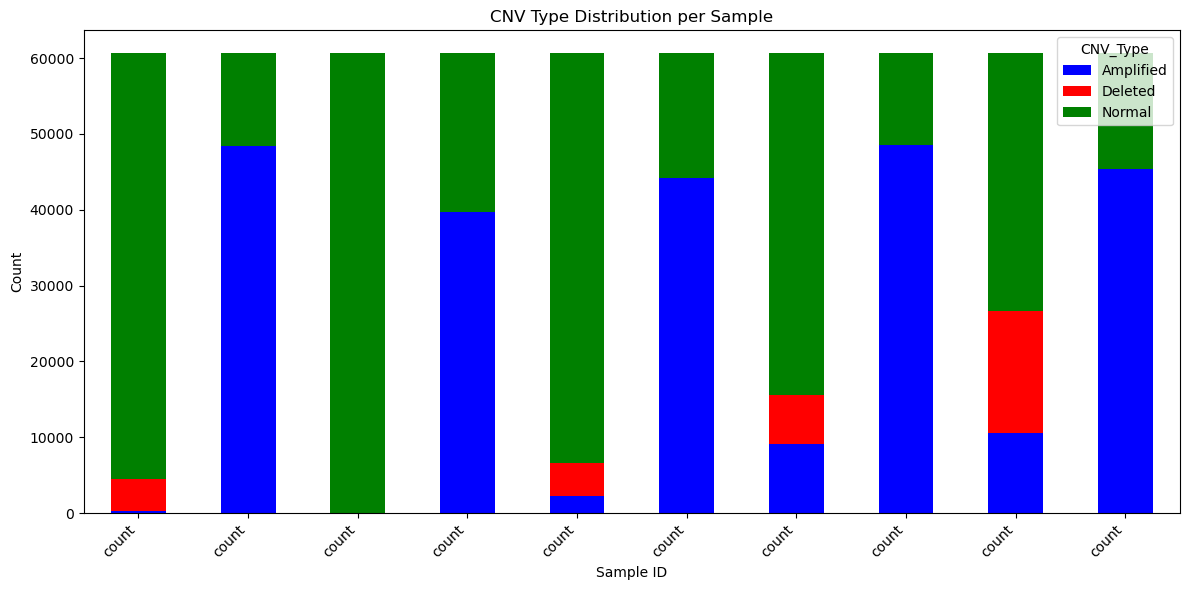

In [89]:
cnv_summary_df = pd.DataFrame(all_cnv_counts)

cnv_summary_df_sorted = cnv_summary_df.sort_index()

cnv_summary_df_sorted.plot(kind='bar', stacked=True, color=['blue', 'red', 'green'], figsize=(12, 6))
plt.title('CNV Type Distribution per Sample')
plt.xlabel('Sample ID')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()